In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
import sortedcontainers as sc
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

In [3]:
class HalfEdge:
    def __init__(self):
        self.vertex = None
        self.twin = None
        self.prev = None
        self.next = None
        self.face = None

class Vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.edge = None


class Face:
    def __init__(self):
        self.visited = False
        self.parent = []
        self.childs =[]
        self.distance = 0
        self.edge = None

In [4]:
def det2x2(a, b):
    return a[0] * b[1] - a[1] * b[0]

In [5]:
# Funkcja do wczytania danych z pliku
def read_data(filename):
    points = []
    triangles = []
    with open(filename, "r") as file:
        # Wczytanie punktów
        n_points = int(file.readline().strip())
        for i in range(n_points):
            x, y = map(float, file.readline().strip().split())
            points.append((x, y))
        # Wczytanie trójkątów
        n_triangles = int(file.readline().strip())
        for i in range(n_triangles):
            v1, v2, v3 = map(int, file.readline().strip().split())
            triangles.append((v1, v2, v3))
    return points, triangles

<IPython.core.display.Javascript object>


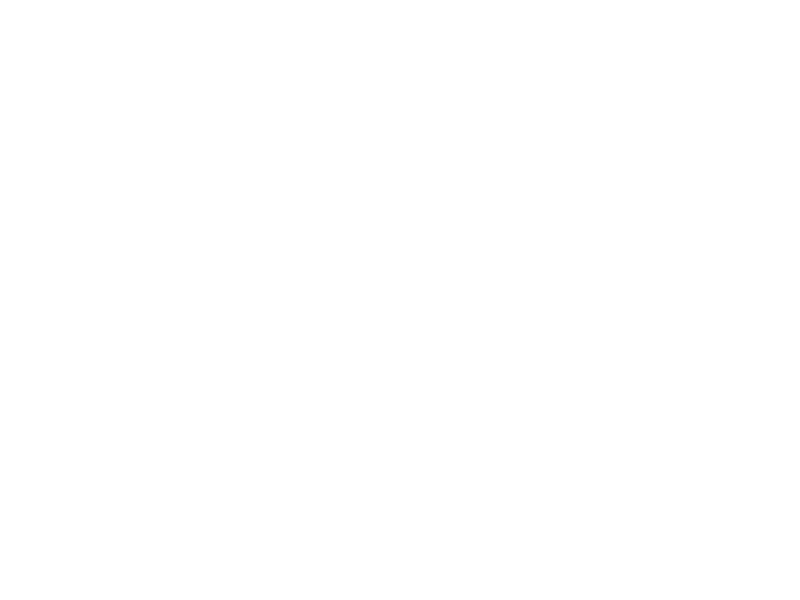

In [6]:
# Wczytanie danych
from time import time
points, triangles = read_data("triangulation_przyklad.txt")

scenes = []
lines = []
scenes.append(Scene([PointsCollection(points.copy())],[LinesCollection(lines.copy())]))
for i in range(len(triangles)):
    a = points[triangles[i][0]]
    b = points[triangles[i][1]]
    c = points[triangles[i][2]]
    lines.append((a,b))
    lines.append((b,c))
    lines.append((a,c))
    #scenes.append(Scene([PointsCollection(points.copy())],[LinesCollection(lines.copy())]))
scenes.append(Scene([PointsCollection(points.copy())],[LinesCollection(lines.copy())]))
plot = Plot(scenes = scenes)
plot.draw()

In [7]:
def to_half_edges(points,triangles):
    half_edges = []

    vertices = []

    faces = []
    
    twin_finder = [[0 for i in range(len(points))] for j in range(len(points))]
    
    # Tworzymy obiekty Vertex dla każdego punktu.
    for point in points:
        x, y = point
        vertex = Vertex(x, y)
        vertices.append(vertex)
        
    for triangle in triangles:
        v1, v2, v3 = triangle
        vertex1 = vertices[v1]
        vertex2 = vertices[v2]
        vertex3 = vertices[v3]
        
        
        # Tworzymy krawędzie połówkowe.
        e1 = HalfEdge()
        e2 = HalfEdge()
        e3 = HalfEdge()
        
        if(twin_finder[v1][v2] != 0):
            e1.twin = twin_finder[v1][v2]
            twin_finder[v1][v2].twin = e1
        
        if(twin_finder[v2][v3] != 0):
            e2.twin = twin_finder[v2][v3]
            twin_finder[v2][v3].twin = e2  
            
        if(twin_finder[v3][v1] != 0):
            e3.twin = twin_finder[v3][v1]
            twin_finder[v3][v1].twin = e3 
            
        twin_finder[v1][v2] = e1
        twin_finder[v2][v3] = e2
        twin_finder[v3][v1] = e3
        twin_finder[v2][v1] = e1
        twin_finder[v3][v2] = e2
        twin_finder[v1][v3] = e3
        
        
        
        face = Face()
        face.edge = e1
        
        e1.face = face
        e2.face = face
        e3.face = face        
        
        det = det2x2([(vertex1.x-vertex3.x), (vertex1.y-vertex3.y)], [(vertex2.x-vertex3.x), (vertex2.y-vertex3.y)])
        if(det > 0):
            vertex1.edge = e1
            vertex2.edge = e2
            vertex3.edge = e3
            e1.vertex = vertex1
            e2.vertex = vertex2
            e3.vertex = vertex3
            e1.next = e2
            e1.prev = e3
            e2.next = e3
            e2.prev = e1
            e3.next = e1
            e3.prev = e2
        else:
            vertex1.edge = e3
            vertex2.edge = e1
            vertex3.edge = e2
            e1.vertex = vertex2
            e2.vertex = vertex3
            e3.vertex = vertex1
            e1.next = e3
            e1.prev = e2
            e2.next = e1
            e2.prev = e3
            e3.next = e2
            e3.prev = e1
            
        faces.append(face)
        half_edges.append(e1)
        half_edges.append(e2)
        half_edges.append(e3)
    
    
    return vertices,half_edges,faces


In [8]:
v,he,f = to_half_edges(points,triangles)
times_normal = [0,0,0,0]
times_half_edge = [0,0,0,0]

In [96]:
#OP1: wyznaczanie otoczenia dla wybranego wierzchołka (kolejne warstwy
#incydentnych wierzchołków – należy rozpatrzyć otoczenia składające się z jednej
#warstwy oraz dwóch warstw)

# wybór wierzchołka z listy
ver = 30
scenesO1 = []
scenesO1.append(Scene([PointsCollection(points.copy()),PointsCollection([points[ver]], color="red")],[LinesCollection(lines.copy())]))

def get_surr(triangles,point_id,surr):
    for triangle in triangles:
        lines2 = []
        a = points[triangle[0]]
        b = points[triangle[1]]
        c = points[triangle[2]]
        lines2.append((a,b))
        lines2.append((b,c))
        lines2.append((a,c))
        scenesO1.append(Scene([PointsCollection(points.copy()),PointsCollection([points[point_id]], color="red")],[LinesCollection(lines.copy()),LinesCollection(lines2.copy(),color="yellow")]))
        if point_id in triangle:
            scenesO1.append(Scene([PointsCollection(points.copy()),PointsCollection([points[point_id]], color="red")],[LinesCollection(lines.copy()),LinesCollection(lines2.copy(),color="green")]))
            for i in triangle:
                surr.append(i)
            if point_id in surr:
                surr.remove(point_id)
    surr = list(dict.fromkeys(surr))
    return surr

def surrounding(triangles,point_id):
    first_surrounding = []
    first_surrounding = get_surr(triangles,point_id,[])
    second_surrounding = []
    for i in first_surrounding:
        second_surrounding = get_surr(triangles,i,second_surrounding)
    for i in first_surrounding:
        if i in second_surrounding:
            second_surrounding.remove(i)
    if point_id in second_surrounding:
        second_surrounding.remove(point_id)
    return first_surrounding,second_surrounding
            

<IPython.core.display.Javascript object>


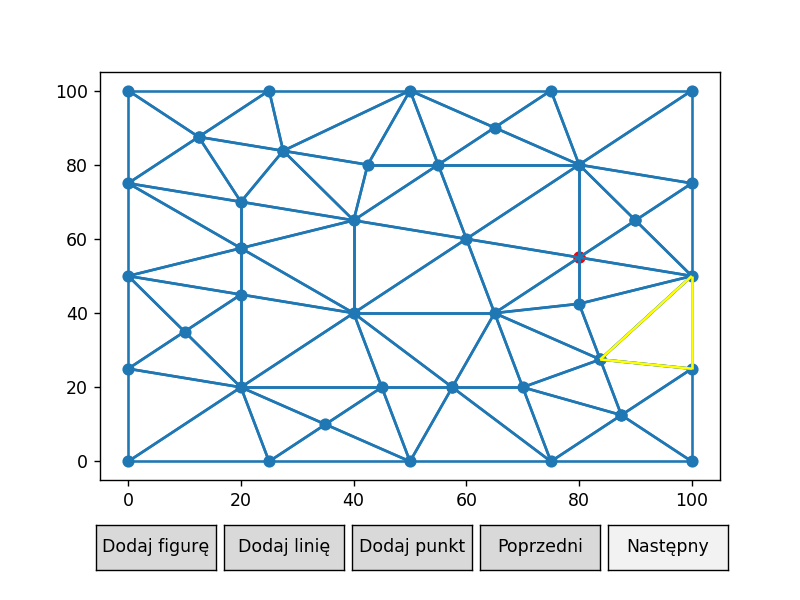

In [97]:

t_before = time()
res1a,res1b = surrounding(triangles,ver)
t_after = time()
times_normal[0] = t_after-t_before
for i in range(len(res1a)):
    res1a[i] = points[res1a[i]]
for i in range(len(res1b)):
    res1b[i] = points[res1b[i]]    
scenesO1.append(Scene([PointsCollection(points.copy()),PointsCollection([points[ver]], color="black"),PointsCollection(res1a, color="orange")],[LinesCollection(lines.copy())]))
scenesO1.append(Scene([PointsCollection(points.copy()),PointsCollection([points[ver]], color="black"),PointsCollection(res1a, color="orange"),PointsCollection(res1b, color="red")],[LinesCollection(lines.copy())]))
plot = Plot(scenes = scenesO1)
plot.draw()

In [98]:
# wybór wierzchołka z listy
ver = v[30]
scenesO2 = []
scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection([(ver.x,ver.y)], color="black")],[LinesCollection(lines.copy())]))


def all_half_edges_leaving(v):
    h = v.edge
    t = h
    while h.twin != None:
        to_visualize = []
        to_visualize.append(((h.vertex.x,h.vertex.y),(h.twin.vertex.x,h.twin.vertex.y)))
        scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection([(ver.x,ver.y)], color="black")],[LinesCollection(lines.copy()),LinesCollection(to_visualize.copy(),color = "yellow")]))
        if h.twin.next != t:
            h = h.twin.next
        else:
            break
    first_edge = h
    edges = []
    edges.append(first_edge)
    h = h.prev
    if h.twin != None:
        w = h.twin
        t = w
        while w != h:
            edges.append(w)
            to_visualize = []
            to_visualize.append(((w.vertex.x,w.vertex.y),(w.twin.vertex.x,w.twin.vertex.y)))
            scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection([(ver.x,ver.y)], color="black")],[LinesCollection(lines.copy()),LinesCollection(to_visualize.copy(),color = "red")]))
            if w.prev.twin != None:
                if w.prev.twin != t:
                    w = w.prev.twin
                else:
                    break
            else:
                break
            
        if w.prev.twin == None:
            w = w.prev
            edges.append(w)
    else:
        edges.append(h)
        
    return edges
        

def surrounding_for_half_edges(vertex):
    out_half_edges = all_half_edges_leaving(vertex)
    return out_half_edges
    

In [99]:
t_before = time()
res1c = surrounding_for_half_edges(ver)


  
for i in range(len(res1c)-1):
    if i == 0:
        res1c[0] = res1c[0].next
    else:
        res1c[i] = res1c[i].twin
        
first_surr = []
second_surr = []

for i in range(len(res1c)):
    first_surr.append(res1c[i].vertex)
if ver in first_surr:
    first_surr.remove(ver)
    
for vertex in first_surr:
    temp = surrounding_for_half_edges(vertex)
    for i in range(len(temp)-1):
        if i == 0:
            temp[0] = temp[0].next
        else:
            temp[i] = temp[i].twin

    for i in temp:
        second_surr.append(i.vertex)

second_surr = list(dict.fromkeys(second_surr))
if ver in second_surr:
    second_surr.remove(ver)

for vertex in first_surr:
    if vertex in second_surr:
        second_surr.remove(vertex)

t_after = time()
times_half_edge[0] = t_after-t_before
        
    

<IPython.core.display.Javascript object>


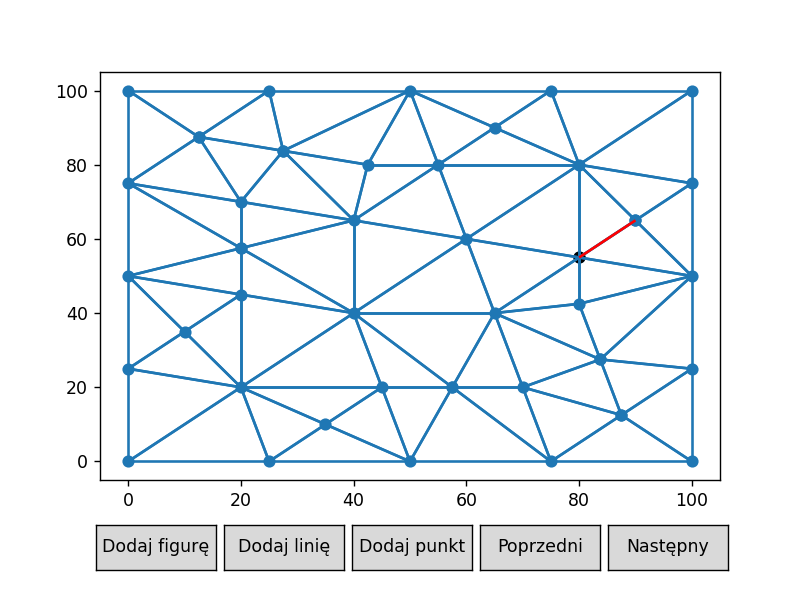

In [100]:

first_points = []  
second_points = []
for vertex in first_surr:
    first_points.append((vertex.x,vertex.y))
for vertex in second_surr:
    second_points.append((vertex.x,vertex.y))
scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection([(ver.x,ver.y)], color="black"),PointsCollection(first_points, color="orange")],[LinesCollection(lines.copy())]))
scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection([(ver.x,ver.y)], color="black"),PointsCollection(first_points, color="orange"),PointsCollection(second_points, color="red")],[LinesCollection(lines.copy())]))
plot2 = Plot(scenes = scenesO2)
plot2.draw()

In [101]:
#OP2: wyznaczanie otoczenia dla wybranego trójkąta (kolejne warstwy incydentnych
#trójkątów – należy rozpatrzyć otoczenia składające się z jednej warstwy oraz dwóch
#warstw)
trian = triangles[4]

def traingle_surrounding(points,triangles,trian):
    v1 = trian[0]
    v2 = trian[1]
    v3 = trian[2]
    incident_triangles = []
    for triangle in triangles:
        count = 0
        if v1 in triangle:
            count += 1
        if v2 in triangle:
            count += 1
        if v3 in triangle:
            count += 1
        if count == 2:
            incident_triangles.append(triangle)
    return incident_triangles
            

In [102]:
t_before = time()
first_triangles_surr = traingle_surrounding(points,triangles,trian)
second_triangles_surr = []
for triangle in first_triangles_surr:
    temp = traingle_surrounding(points,triangles,triangle)
    for t in temp:
        second_triangles_surr.append(t)
        
second_triangles_surr = list(dict.fromkeys(second_triangles_surr))
if trian in second_triangles_surr:
    second_triangles_surr.remove(trian)

for triangle in first_triangles_surr:
    if triangle in second_triangles_surr:
        second_triangles_surr.remove(triangle)

t_after = time()
times_normal[1] = t_after-t_before

<IPython.core.display.Javascript object>


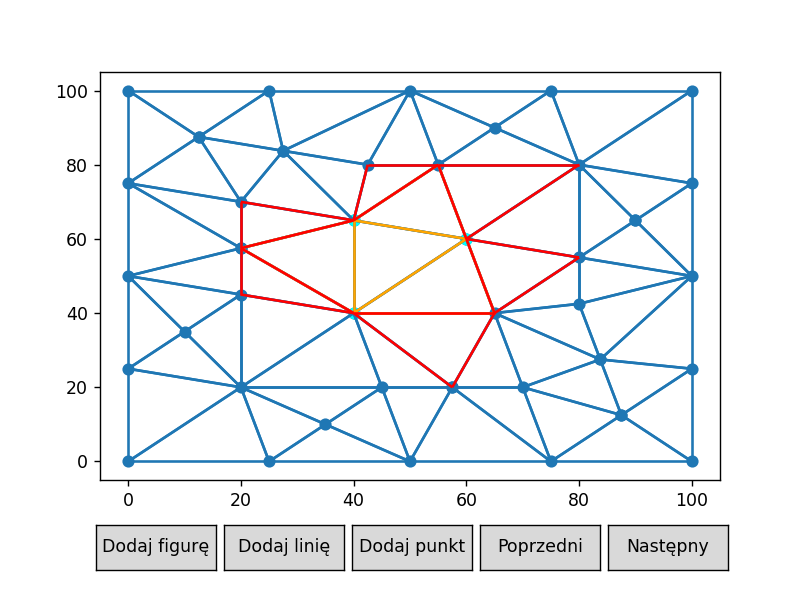

In [103]:
vers = []
vers.append(points[trian[0]])
vers.append(points[trian[1]])
vers.append(points[trian[2]])

first_triangles = []  
second_triangles = []

for triangle in first_triangles_surr:
    a = points[triangle[0]]
    b = points[triangle[1]]
    c = points[triangle[2]]
    first_triangles.append((a,b))
    first_triangles.append((b,c))
    first_triangles.append((a,c))
for triangle in second_triangles_surr:
    a = points[triangle[0]]
    b = points[triangle[1]]
    c = points[triangle[2]]
    second_triangles.append((a,b))
    second_triangles.append((b,c))
    second_triangles.append((a,c))
scenesO2 = []
scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua")],[LinesCollection(lines.copy())]))
scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua")],[LinesCollection(lines.copy()),LinesCollection(first_triangles,color = "orange")]))
scenesO2.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua")],[LinesCollection(lines.copy()),LinesCollection(first_triangles,color = "orange"),LinesCollection(second_triangles,color = "red")]))
plot2 = Plot(scenes = scenesO2)
plot2.draw()

In [104]:
trian2 = f[4]

def first_sur(face):
    e1 = face.edge
    e2 = e1.next
    e3 = e2.next
    first_s = []
    if e1.twin != None:
        first_s.append(e1.twin.face)
    if e2.twin != None:
        first_s.append(e2.twin.face)
    if e3.twin != None:
        first_s.append(e3.twin.face)
    return first_s

def traingle_surrounding_for_half_edges(face):
    first_s = first_sur(face)
    second_s = []
    for f in first_s:
        temp = first_sur(f)
        for fa in temp:
            second_s.append(fa)
    return first_s,second_s


In [105]:
t_before = time()
first,second = traingle_surrounding_for_half_edges(trian2)
second = list(dict.fromkeys(second))
if trian2 in second:
    second.remove(trian2)

for triangle in first:
    if triangle in second:
        second.remove(triangle)
        
t_after = time()
times_half_edge[1] = t_after-t_before

<IPython.core.display.Javascript object>


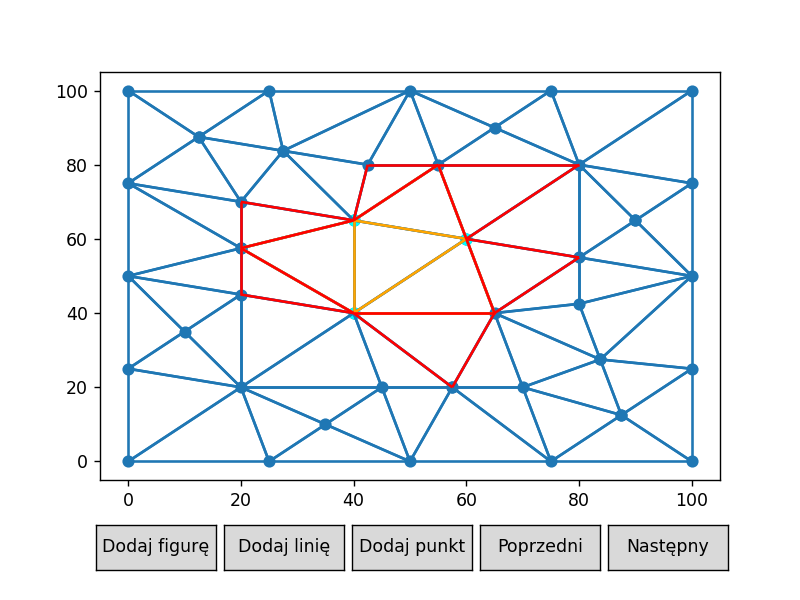

In [106]:
vers = []
e1 = trian2.edge
vers.append((e1.vertex.x,e1.vertex.y))
vers.append((e1.next.vertex.x,e1.next.vertex.y))
vers.append((e1.next.next.vertex.x,e1.next.next.vertex.y))

first_to_show = []
second_to_show = []
for face in first:
    e1 = face.edge
    e2 = e1.next
    e3 = e2.next
    a = e1.vertex
    b = e2.vertex
    c = e3.vertex
    first_to_show.append(((a.x,a.y),(b.x,b.y)))
    first_to_show.append(((a.x,a.y),(c.x,c.y)))
    first_to_show.append(((c.x,c.y),(b.x,b.y)))
for face in second:
    e1 = face.edge
    e2 = e1.next
    e3 = e2.next
    a = e1.vertex
    b = e2.vertex
    c = e3.vertex
    second_to_show.append(((a.x,a.y),(b.x,b.y)))
    second_to_show.append(((a.x,a.y),(c.x,c.y)))
    second_to_show.append(((c.x,c.y),(b.x,b.y)))
scenesO3 = []
scenesO3.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua")],[LinesCollection(lines.copy())]))
scenesO3.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua")],[LinesCollection(lines.copy()),LinesCollection(first_to_show,color = "orange")]))
scenesO3.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua")],[LinesCollection(lines.copy()),LinesCollection(first_to_show,color = "orange"),LinesCollection(second_to_show,color = "red")]))
plot3 = Plot(scenes = scenesO3)
plot3.draw()

In [107]:
#OP3: przeglądanie incydentnych trójkątów od wybranego trójkąta w kierunku
#wybranego punktu (dla odszukania trójkąta zawierającego dany punkt)

t = 0
selected_point = 6
triangles_with_point = []

for i in range(len(triangles)):
    if selected_point in triangles[i]:
        triangles_with_point.append(i)
               
selected_triangle = triangles[t]



def bfs_for_triangles(triangles,t):
    n = len(triangles)
    visited = [False for i in range(n)]
    parent = [None for i in range(n)]
    childs = [[] for i in range(n)]
    d = [0 for i in range(n)]
    queue = []
    queue.append(t)
    visited[t] = True
    while queue:
        # t indeks aktualnie przeglądanego trójkąta
        t = queue.pop(0)
        v1 = triangles[t][0]
        v2 = triangles[t][1]
        v3 = triangles[t][2]
        for i in range(n):
            if visited[i] == False:
                count = 0
                if v1 in triangles[i]:
                    count += 1
                if v2 in triangles[i]:
                    count += 1
                if v3 in triangles[i]:
                    count += 1
                if count == 2:
                    queue.append(i)
                    visited[i] = True
                    parent[i] = t
                    childs[t].append(i)
                    d[i] = d[t] +1
    return visited,parent,d,childs


In [108]:
t_before = time()
visited,parent,d,childs = bfs_for_triangles(triangles,t)

minimum_d = d[triangles_with_point[0]]
closest_triuangle = triangles_with_point[0]

for i in range(len(triangles_with_point)):
    if d[triangles_with_point[i]] < minimum_d:
        minimum_d = d[triangles_with_point[i]]
        closest_triuangle = triangles_with_point[i]

t_after = time()
times_normal[2] = t_after-t_before

<IPython.core.display.Javascript object>


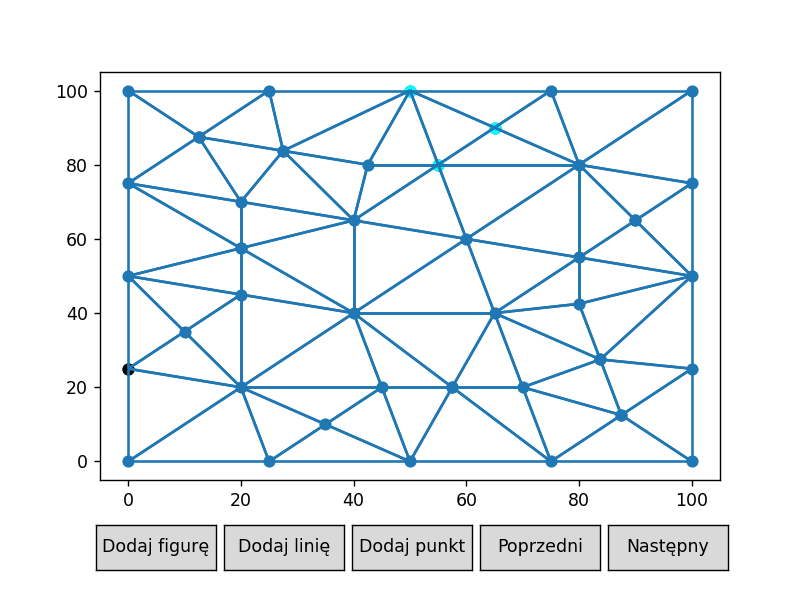

In [112]:
vers = []
vers.append(points[triangles[t][0]])
vers.append(points[triangles[t][1]])
vers.append(points[triangles[t][2]])
point = []
point.append(points[selected_point])

scenesO4 = []
scenesO4.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua"),PointsCollection(point, color="black")],[LinesCollection(lines.copy())]))
next_surr = []
next_surr += childs[t]
while len(next_surr) > 0:
    if d[next_surr[0]] <= minimum_d:
        next_triangles = []
        for i in next_surr:
            a = points[triangles[i][0]]
            b = points[triangles[i][1]]
            c = points[triangles[i][2]]
            next_triangles.append((a,b))
            next_triangles.append((b,c))
            next_triangles.append((a,c))
        scenesO4.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua"),PointsCollection(point, color="black")],[LinesCollection(lines.copy()),LinesCollection(next_triangles.copy(),color = "red")]))
        temp = []
        for i in next_surr:
            temp += childs[i]
        next_surr = temp
    else:
        break

path = []
w = parent[closest_triuangle]
path.append(closest_triuangle)
while w != None:
    path.append(w)
    w = parent[w]
path.reverse()
for i in range(len(path)):
    next_triangle = []
    a = points[triangles[path[i]][0]]
    b = points[triangles[path[i]][1]]
    c = points[triangles[path[i]][2]]
    next_triangle.append((a,b))
    next_triangle.append((b,c))
    next_triangle.append((a,c))
    scenesO4.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua"),PointsCollection(point, color="black")],[LinesCollection(lines.copy()),LinesCollection(next_triangle.copy(),color = "red")]))

    
    

plot4 = Plot(scenes = scenesO4)
plot4.draw()

In [128]:
# face 
t = 1
# point
s = 3
selected_point = v[s]
selected_face = f[t]

faces_with_point = []

for face in f:
    e1 = face.edge
    e2 = e1.next
    e3 = e2.next
    v1 = e1.vertex
    v2 = e2.vertex
    v3 = e3.vertex
    if v1 == selected_point:
        faces_with_point.append(face)
    if v2 == selected_point:
        faces_with_point.append(face)
    if v3 == selected_point:
        faces_with_point.append(face)
    

def bfs_for_faces(faces,face):
    n = len(faces)
    d = [[] for i in range(n)]
    d[0].append(face)
    queue = []
    queue.append(face)
    face.visited = True
    while queue:
        t = queue.pop(0)
        e1 = t.edge
        e2 = e1.next
        e3 = e2.next
        if e1.twin != None:
            if e1.twin.face.visited == False:
                f1 = e1.twin.face
                f1.visited = True
                f1.distance = t.distance+1
                t.childs.append(f1)
                f1.parent.append(t)
                d[f1.distance].append(f1)
                queue.append(f1)
        if e2.twin != None:
            if e2.twin.face.visited == False:
                f2 = e2.twin.face
                f2.visited = True
                f2.distance = t.distance+1
                t.childs.append(f2)
                f2.parent.append(t)
                d[f2.distance].append(f2)
                queue.append(f2)
        if e3.twin != None:
            if e3.twin.face.visited == False:
                f3 = e3.twin.face
                f3.visited = True
                f3.distance = t.distance+1
                t.childs.append(f3)
                f3.parent.append(t)
                d[f3.distance].append(f3)
                queue.append(f3)
    for face in faces:
        face.visited = False
    return d

In [129]:
t_before = time()
distances = bfs_for_faces(f,selected_face)

closest_face = faces_with_point[0]
minimum_d = closest_face.distance

for face in faces_with_point:
    if face.distance < minimum_d:
        minimum_d = face.distance
        closest_face = face
        
t_after = time()
times_half_edge[2] = t_after-t_before


<IPython.core.display.Javascript object>


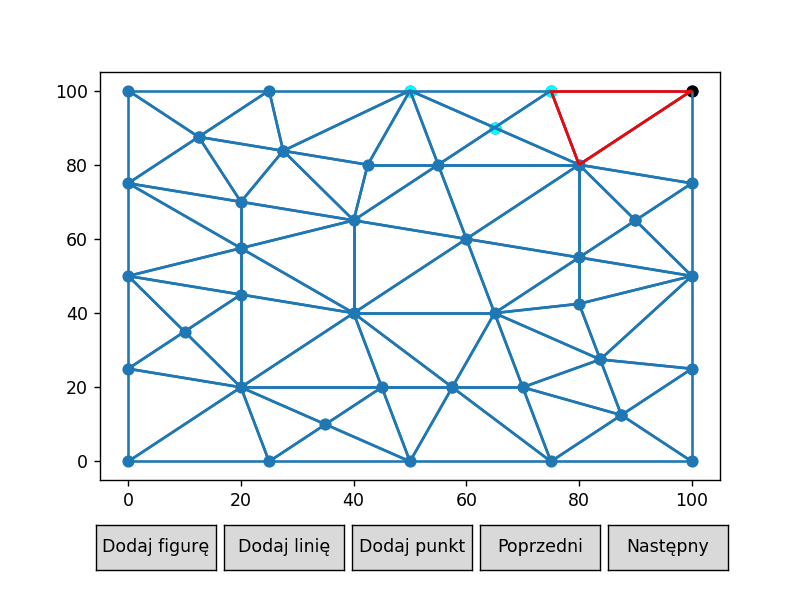

In [130]:
point = [(selected_point.x,selected_point.y)]
vers = []
e1 = selected_face.edge
vers.append((e1.vertex.x,e1.vertex.y))
vers.append((e1.next.vertex.x,e1.next.vertex.y))
vers.append((e1.next.next.vertex.x,e1.next.next.vertex.y))
path = []
path.append(closest_face)
w = closest_face.parent[0]
while w:
    path.append(w)
    if w.parent:
        w = w.parent[0]
    else:
        break
path.reverse()
scenesO5 = []
scenesO5.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua"),PointsCollection(point, color="black")],[LinesCollection(lines.copy())]))
for i in range(minimum_d+1):
    actual_surr = []
    for tri in distances[i]:
        e1 = tri.edge
        e2 = e1.next
        e3 = e2.next
        a = e1.vertex
        b = e2.vertex
        c = e3.vertex
        actual_surr.append(((a.x,a.y),(b.x,b.y)))
        actual_surr.append(((a.x,a.y),(c.x,c.y)))
        actual_surr.append(((c.x,c.y),(b.x,b.y)))
    scenesO5.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua"),PointsCollection(point, color="black")],[LinesCollection(lines.copy()),LinesCollection(actual_surr.copy(),color = "red")]))
for i in path:
    actual_triangle = []
    e1 = i.edge
    e2 = e1.next
    e3 = e2.next
    a = e1.vertex
    b = e2.vertex
    c = e3.vertex
    actual_triangle.append(((a.x,a.y),(b.x,b.y)))
    actual_triangle.append(((a.x,a.y),(c.x,c.y)))
    actual_triangle.append(((c.x,c.y),(b.x,b.y)))
    scenesO5.append(Scene([PointsCollection(points.copy()),PointsCollection(vers, color="aqua"),PointsCollection(point, color="black")],[LinesCollection(lines.copy()),LinesCollection(actual_triangle.copy(),color = "red")]))
plot5 = Plot(scenes = scenesO5)
plot5.draw()

<IPython.core.display.Javascript object>


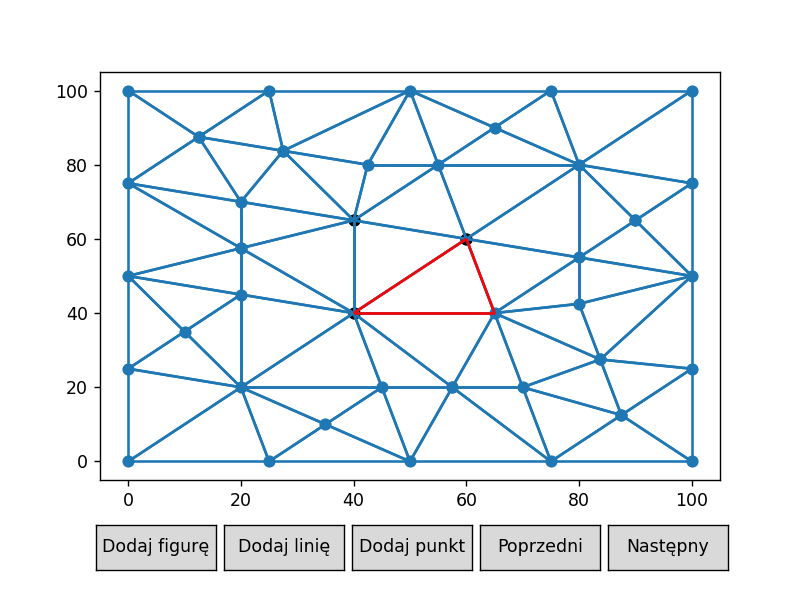

In [131]:
# OP4: zamiana krawędzi dla wskazanej pary incydentnych trójkątów.

t_before = time()
triangle = triangles[6]
incydent_triangles = traingle_surrounding(points,triangles,triangle)
# 0 , 1 lub 2
choosen_triangle = incydent_triangles[0]

vers = []
vers.append(points[triangle[0]])
vers.append(points[triangle[1]])
vers.append(points[triangle[2]])

incydent_triangle = []
a = points[choosen_triangle[0]]
b = points[choosen_triangle[1]]
c = points[choosen_triangle[2]]
incydent_triangle.append((a,b))
incydent_triangle.append((b,c))
incydent_triangle.append((a,c))

t_bb = time()
scenesO6 = []
scenesO6.append(Scene([PointsCollection(points.copy()),PointsCollection(vers.copy(), color="black")],[LinesCollection(lines.copy())]))
scenesO6.append(Scene([PointsCollection(points.copy()),PointsCollection(vers.copy(), color="black")],[LinesCollection(lines.copy()),LinesCollection(incydent_triangle.copy(),color = "red")]))
t_aa = time()

incydent_triangles = traingle_surrounding(points,triangles,triangle)
temp_tirangle = triangle
triangle = choosen_triangle
choosen_triangle = temp_tirangle

vers = []
vers.append(points[triangle[0]])
vers.append(points[triangle[1]])
vers.append(points[triangle[2]])

incydent_triangle = []
a = points[choosen_triangle[0]]
b = points[choosen_triangle[1]]
c = points[choosen_triangle[2]]
incydent_triangle.append((a,b))
incydent_triangle.append((b,c))
incydent_triangle.append((a,c))

t_after = time()
times_normal[3] = t_after-t_before-t_aa+t_bb

scenesO6.append(Scene([PointsCollection(points.copy()),PointsCollection(vers.copy(), color="black")],[LinesCollection(lines.copy()),LinesCollection(incydent_triangle.copy(),color = "red")]))

plot6 = Plot(scenes = scenesO6)
plot6.draw()

<IPython.core.display.Javascript object>


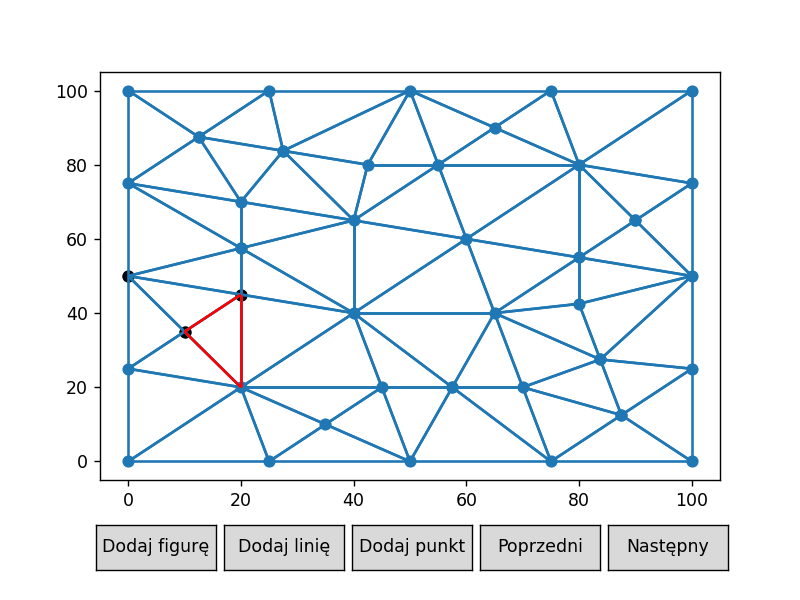

In [132]:
t_before = time()
trian4 = f[2]
incident_faces = first_sur(trian4)
choosen_face = incident_faces[0]

vers = []
e1 = trian4.edge
vers.append((e1.vertex.x,e1.vertex.y))
vers.append((e1.next.vertex.x,e1.next.vertex.y))
vers.append((e1.next.next.vertex.x,e1.next.next.vertex.y))

incydent_face = []
e2 = choosen_face.edge
a = (e2.vertex.x,e2.vertex.y)
b = (e2.next.vertex.x,e2.next.vertex.y)
c = (e2.next.next.vertex.x,e2.next.next.vertex.y)
incydent_face.append((a,b))
incydent_face.append((b,c))
incydent_face.append((a,c))

t_bb = time()

scenesO7 = []
scenesO7.append(Scene([PointsCollection(points.copy()),PointsCollection(vers.copy(), color="black")],[LinesCollection(lines.copy())]))
scenesO7.append(Scene([PointsCollection(points.copy()),PointsCollection(vers.copy(), color="black")],[LinesCollection(lines.copy()),LinesCollection(incydent_face.copy(),color = "red")]))

t_aa = time()

temp_face = trian4.edge
trian4.edge = choosen_face.edge
choosen_face.edge = temp_face

vers = []
e1 = trian4.edge
vers.append((e1.vertex.x,e1.vertex.y))
vers.append((e1.next.vertex.x,e1.next.vertex.y))
vers.append((e1.next.next.vertex.x,e1.next.next.vertex.y))

incydent_face = []
e2 = choosen_face.edge
a = (e2.vertex.x,e2.vertex.y)
b = (e2.next.vertex.x,e2.next.vertex.y)
c = (e2.next.next.vertex.x,e2.next.next.vertex.y)
incydent_face.append((a,b))
incydent_face.append((b,c))
incydent_face.append((a,c))

e1.face = choosen_face
e1.next.face = choosen_face
e1.prev.face = choosen_face
e2.face = trian4 
e2.next.face = trian4 
e2.prev.face = trian4 

t_after = time()
times_half_edge[3] = t_after-t_before-t_aa+t_bb
scenesO7.append(Scene([PointsCollection(points.copy()),PointsCollection(vers.copy(), color="black")],[LinesCollection(lines.copy()),LinesCollection(incydent_face.copy(),color = "red")]))

plot7 = Plot(scenes = scenesO7)
plot7.draw()

In [28]:
print(times_normal)
print(times_half_edge)

[0.0, 0.0, 0.0009984970092773438, 0.0]
[0.0, 0.0, 0.0, 0.0]
